# Patient Risk Profiling Using K-Means Clustering on Heart Disease Data

## Introduction

In this notebook, we will explore **unsupervised machine learning** techniques to cluster patients based on their clinical features. Specifically, we will use **K-Means Clustering** to identify **latent cardiovascular risk profiles** in the UCI Heart Disease dataset. 

Unsupervised learning is particularly useful in healthcare scenarios where labels may not always be available, or where we want to **discover hidden patterns** in patient data. Clustering can help in:

- Segmenting patients into distinct risk groups.
- Identifying groups that may benefit from targeted interventions.
- Supporting clinical decision-making by revealing underlying patterns.

## Why K-Means?

K-Means is a **widely used clustering algorithm** that assigns data points to clusters based on feature similarity. It is efficient, easy to implement, and works well with **numerical clinical data**. In this notebook, we will:

1. Explore and clean the dataset, handling missing values and preprocessing features.
2. Scale the data to ensure fair distance calculations.
3. Determine the optimal number of clusters using the **Elbow Method**.
4. Train a K-Means model and analyze the resulting clusters.
5. Visualize clusters using **Principal Component Analysis (PCA)** for dimensionality reduction.
6. Discuss insights, limitations, and potential applications in healthcare.

## 1. Library Imports

Before we begin, we need to import the necessary Python libraries for data manipulation, visualization, preprocessing, and machine learning.

- **pandas**: For loading, inspecting, and manipulating tabular data.
- **numpy**: For numerical operations and array handling.
- **matplotlib & seaborn**: For creating visualizations to understand patterns and cluster structures.
- **scikit-learn (sklearn)**: Provides preprocessing utilities, clustering algorithms (K-Means), and dimensionality reduction (PCA).
- **warnings**: To filter out unnecessary warnings and keep the notebook clean.

We will also ensure that any random operations are reproducible by setting a `random_state` where appropriate.


In [1]:
# Data manipulation
import pandas as pd  # For handling tabular data
import numpy as np  # For numerical operations

# Data visualization
import matplotlib.pyplot as plt  # Core plotting library
import seaborn as sns  # Advanced, aesthetically pleasing plots

# Machine learning
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Feature scaling and encoding
from sklearn.cluster import KMeans  # K-Means clustering algorithm
from sklearn.decomposition import PCA  # Principal Component Analysis for visualization

# Miscellaneous
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings to keep the notebook clean

# Set global seaborn style for all plots
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Set random seed for reproducibility (used later in KMeans and PCA)
RANDOM_STATE = 42

## 2. Loading and Inspecting the Heart Disease Dataset

For this project, we will use the **UCI Heart Disease dataset**, a widely recognized dataset in healthcare analytics. This dataset contains clinical measurements and demographic information for patients and is commonly used to study cardiovascular disease risk factors.

**Key points about this dataset:**

- Contains **both numerical and categorical features** such as age, sex, blood pressure, cholesterol, chest pain type, and others.
- Includes some **missing or inconsistent values**, which makes it ideal for practicing real-world data cleaning and preprocessing.
- While the dataset has an `num` column indicating the presence of heart disease, for the purposes of **unsupervised learning**, we will **ignore this label during clustering**. Later, we may use it to interpret the clusters.

**Goals for this step:**

1. Load the dataset into a pandas DataFrame.
2. Explore its **shape, column names, and basic statistics**.
3. Identify missing values or inconsistencies.
4. Understand the types of features we will need to preprocess before clustering.

By carefully inspecting the dataset at this stage, we ensure that our **data cleaning and preprocessing steps are well-informed**.

In [2]:
# Load dataset
data = pd.read_csv('heart_disease_uci.csv')

# Preview the first 5 rows
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Initial Data Preview


From the preview above, we observe that each row represents a **single patient record**, identified by a unique `id`. The dataset includes a mix of:

- **Demographic features** such as age and sex
- **Clinical measurements** such as resting blood pressure (`trestbps`), cholesterol (`chol`), and maximum heart rate achieved (`thalch`)
- **Categorical clinical indicators** including chest pain type (`cp`), ECG results (`restecg`), exercise-induced angina (`exang`), and thalassemia status (`thal`)
- A target-like column `num` indicating the degree of heart disease presence

At this stage, it is important to note that although the `num` column represents disease severity, **we will not use it during clustering**, since K-Means is an unsupervised learning algorithm. Instead, this column may later help us interpret and validate the resulting clusters.

In [3]:
# Load data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


### Dataset Structure and Data Types

The dataset contains **920 patient records** and **16 columns**, indicating a moderately sized tabular dataset suitable for clustering analysis. The features include:

- **Numerical variables** (`int64` and `float64`), such as age, cholesterol, resting blood pressure, and ST depression
- **Categorical variables** (`object`), such as sex, chest pain type, ECG results, and slope of the ST segment

A key observation is that several clinical features are stored as **categorical text values**, even though they represent structured medical categories. Since K-Means relies on **distance-based calculations**, these features will need to be **encoded into numerical form** before modeling.

Additionally, the presence of multiple numerical features with different units and ranges highlights the necessity of **feature scaling**, which we will address later using standardization.

In [4]:
# Check for missing values
missing_values = data.isna().sum().to_frame(name="Missing Values")
print(missing_values)

          Missing Values
id                     0
age                    0
sex                    0
dataset                0
cp                     0
trestbps              59
chol                  30
fbs                   90
restecg                2
thalch                55
exang                 55
oldpeak               62
slope                309
ca                   611
thal                 486
num                    0


### Missing Values Analysis

From the summary above, we observe that:

- Several key clinical features, such as `trestbps`, `chol`, `thalch`, and `oldpeak`, have **moderate amounts of missing data**.
- Some variables, notably `ca` (number of major vessels) and `thal`, have **a substantial proportion of missing values**.
- Other features, including age, sex, and the target column `num`, are fully populated.

These missing values cannot be ignored, as K-Means does not handle missing data natively. In the next steps, we will carefully decide how to address them using appropriate strategies such as **imputation or feature exclusion**, guided by both statistical reasoning and healthcare context.

In [5]:
# Checking for duplicate values
duplicated = data.duplicated().sum()
print("No. of duplicated values:", duplicated)

No. of duplicated values: 0


## 3. Data Cleaning and Preprocessing

K-Means clustering is a **distance-based algorithm**, meaning that:
- Missing values cannot be handled directly.
- Irrelevant or redundant features can distort distance calculations.
- Categorical variables must be properly encoded.
- Features must be on comparable scales.

Poor data quality at this stage can lead to **misleading clusters**, regardless of how well the algorithm is implemented.

We will follow a structured approach:

1. **Remove non-informative or identifier columns**  
   Columns such as unique `id` or `dataset` labels do not contribute meaningful information for clustering and can introduce noise.

2. **Handle missing values thoughtfully**  
   Missing data is common in healthcare and may occur due to skipped tests or incomplete records. We will decide when to:
   - Drop features with excessive missingness
   - Impute missing values using appropriate statistical strategies

3. **Encoding Categorical Variables**  
   Categorical clinical attributes (e.g., chest pain type, ECG results) must be transformed into numerical representations suitable for distance-based learning.

4. **Feature scaling**  
   All remaining features will be prepared for scaling prior to clustering.

### 3.1 Drop Non-informative Columns

In [6]:
data = data.drop(columns=['id', 'dataset'])

### 3.2 Dealing with Missing Values

In [7]:
# Calculate the number of missing values per column
missing_counts = data.isna().sum()

# Calculate missing percentage
missing_percentage = round((missing_counts / len(data)) * 100)

# Missing counts summary
missing_summary = pd.DataFrame({
    "missing counts": missing_counts,
    "missing percentage": missing_percentage
}).query("`missing percentage` > 0").sort_values(by='missing percentage', ascending=False)

missing_summary

,missing counts,missing percentage
ca,611,66.0
thal,486,53.0
slope,309,34.0
fbs,90,10.0
oldpeak,62,7.0
trestbps,59,6.0
thalch,55,6.0
exang,55,6.0
chol,30,3.0


### Missing Value Analysis

- **High missingness (>50%)**  
  - `ca` (number of major vessels) and `thal` (thalassemia test result) have more than half of their values missing.
  - Imputing these features would require strong assumptions and could introduce significant noise.
  - In real-world healthcare ML workflows, such features are often **excluded** unless they are clinically indispensable.

- **Moderate missingness (30–50%)**  
  - `slope` shows a substantial amount of missing data.
  - This feature may still be retained depending on its importance, but requires careful imputation and validation.

- **Low missingness (<10%)**  
  - Features such as `chol`, `trestbps`, `thalch`, `exang`, `oldpeak`, and `fbs` have relatively small proportions of missing values.
  - These can be safely handled using appropriate imputation strategies without significantly distorting the dataset.

### Cleaning Strategy

1. **Drop features with excessive missingness**  
   - Columns with more than ~50% missing values (`ca`, `thal`) will be removed from the analysis.

2. **Impute remaining missing values**  
   - Numerical features will be imputed using robust statistics such as the **median**, which is less sensitive to outliers.
   - Categorical features will be imputed using the **mode** (most frequent category).

In [8]:
# Drop columns with high missingness
data = data.drop(columns=['ca', 'thal'])

In [9]:
# Separate features from labels
X = data.drop(columns=['num'])
y = data['num']

# Get numerical and categorical columns
num_cols = X.select_dtypes(include='number').columns
cat_cols = X.select_dtypes(exclude='number').columns

In [10]:
# Fill missing values in numerical columns with median
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Fill missing values in categorical columns with mode
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

### 3.3 Encoding Categorical Variables

In [11]:
# Check for unique values
for col in cat_cols:
    unique = X[col].unique().tolist()
    print(f'=== {col} ===')
    print(unique, '\n')

=== sex ===
['Male', 'Female'] 

=== cp ===
['typical angina', 'asymptomatic', 'non-anginal', 'atypical angina'] 

=== fbs ===
[True, False] 

=== restecg ===
['lv hypertrophy', 'normal', 'st-t abnormality'] 

=== exang ===
[False, True] 

=== slope ===
['downsloping', 'flat', 'upsloping'] 



In [12]:
# Binary encoding
binary_map = {
    'Male': 1,
    'Female': 0,
    True: 1,
    False: 0
}

for col in ['sex', 'fbs', 'exang']:
    X[col] = X[col].map(binary_map)

In [13]:
# Ordinal Encoding
ordinal_map = {
    'downsloping': 0,
    'flat': 1,
    'upsloping': 2
}

X['slope'] = X['slope'].map(ordinal_map)

In [14]:
# One-hot Encoding
for col in ['cp', 'restecg']:
    ohe = OneHotEncoder()
    matrix = ohe.fit_transform(X[[col]]).toarray()
    categories = ohe.get_feature_names_out([col])
    X[categories] = matrix
    X = X.drop(columns=[col])

X.head()

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,slope,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality
0,63,1,145.0,233.0,1,150.0,0,2.3,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,67,1,160.0,286.0,0,108.0,1,1.5,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,67,1,120.0,229.0,0,129.0,1,2.6,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,37,1,130.0,250.0,0,187.0,0,3.5,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,41,0,130.0,204.0,0,172.0,0,1.4,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 3.4 Feature Scaling

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[ 1.00738556,  0.51693097,  0.70517639,  0.30364317,  2.38047614,
         0.4897271 , -0.76029244,  1.36810909, -2.23408054, -1.08157816,
        -0.48295338, -0.53377542,  4.35889894,  1.97322503, -1.2275227 ,
        -0.49149308],
       [ 1.43203377,  0.51693097,  1.51856943,  0.78996695, -0.42008403,
        -1.18147797,  1.31528336,  0.61158896, -0.29506724,  0.92457488,
        -0.48295338, -0.53377542, -0.22941573,  1.97322503, -1.2275227 ,
        -0.49149308],
       [ 1.43203377,  0.51693097, -0.65047866,  0.26693949, -0.42008403,
        -0.34587544,  1.31528336,  1.65180414, -0.29506724,  0.92457488,
        -0.48295338, -0.53377542, -0.22941573,  1.97322503, -1.2275227 ,
        -0.49149308],
       [-1.75282779,  0.51693097, -0.10821664,  0.45963382, -0.42008403,
         1.96197918, -0.76029244,  2.50288928, -2.23408054, -1.08157816,
        -0.48295338,  1.87344707, -0.22941573, -0.50678457,  0.81464888,
        -0.49149308],
       [-1.32817959, -1.93449426, -0

## 4. Training the K-Means Clustering Model

After completing data cleaning, encoding categorical variables, and scaling all features, we are now ready to apply **K-Means clustering** to the heart disease dataset.

### Choosing the Number of Clusters

One of the most important decisions when using K-Means is selecting the appropriate number of clusters, denoted by *k*. 

In this notebook, we will use the **Elbow Method** to guide our choice of *k*. This method involves:

1. Training multiple K-Means models using different values of *k*.
2. Measuring the **inertia**, which represents the total within-cluster sum of squared distances.
3. Plotting inertia against the number of clusters and identifying a point where the rate of improvement slows significantly—the “elbow”.

It is important to note that the elbow method does not provide a mathematically optimal solution. Rather, it serves as a **practical guideline**, and the final choice of *k* should also consider domain knowledge and interpretability.

### Model Training and Visualization

Once a suitable number of clusters has been selected, we will:

- Train a final K-Means model using the chosen value of *k*.
- Assign each patient to a cluster.
- Use **Principal Component Analysis (PCA)** to project the high-dimensional feature space into two dimensions for visualization purposes.

PCA is used here **only for visualization**, not for training the clustering model. This allows us to visually inspect the separation and structure of the discovered patient groups while preserving as much variance as possible.

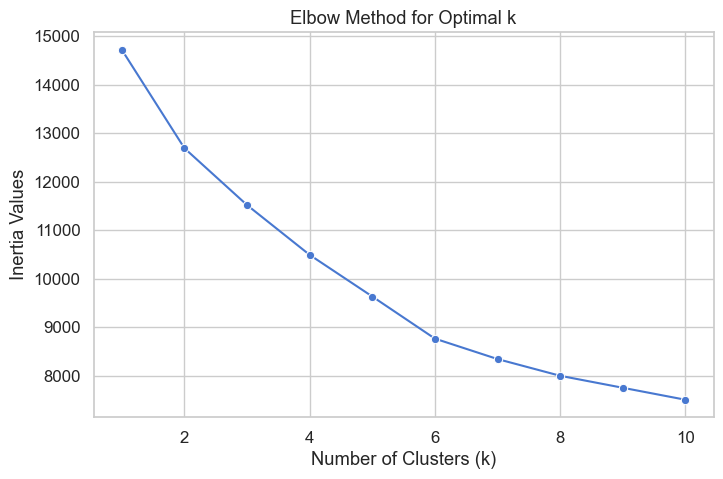

In [16]:
# Choosing no. of clusters using the Elbow Method
inertia_values = []

k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        random_state=42
    )

    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

cluster_data = pd.DataFrame({
    'clusters': k_range,
    'inertia': inertia_values
})


plt.figure(figsize=(8, 5))
sns.lineplot(data=cluster_data, x='clusters', y='inertia', marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Values')
plt.show()

### Choosing the Optimal Number of Clusters


- **Inertia** measures the sum of squared distances between data points and their assigned cluster centroids.
- As `k` increases, inertia will always decrease, because more clusters allow points to be closer to centroids.
- The goal is to identify a value of `k` where the rate of improvement **starts to diminish** — this point is referred to as the *elbow*.


From these values, we observe:

- A **steep reduction in inertia** from `k = 1` to `k = 4`
- After `k = 4`, the decrease in inertia becomes more gradual
- This indicates diminishing returns when adding more clusters beyond this point

### Final Choice of k

Based on the elbow method, we select:

**k = 4**

This choice represents a good balance between:
- Capturing meaningful structure in the data
- Avoiding unnecessary model complexity

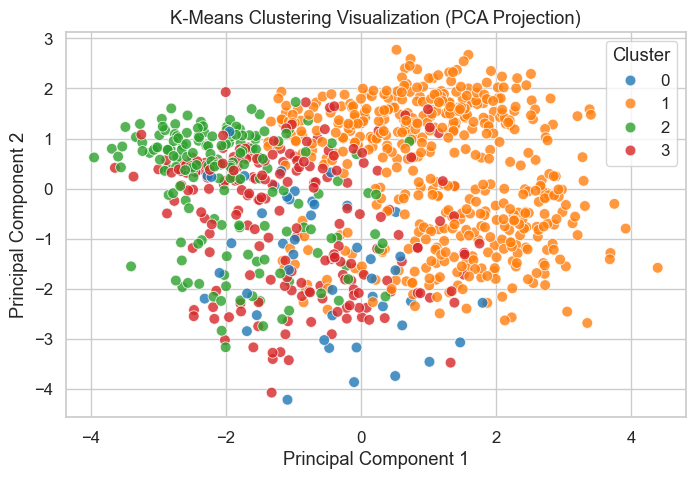

In [17]:
kmeans = KMeans(
    n_clusters=4,
    init="k-means++",
    n_init=10,
    random_state=42
)

clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Cluster": clusters
})

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="tab10",
    s=60,
    alpha=0.8
)

plt.title("K-Means Clustering Visualization (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

### Cluster Visualization and Observations

To better understand the structure of the clusters learned by the K-Means algorithm, we projected the high-dimensional feature space onto **two principal components** using **Principal Component Analysis (PCA)**. This allows us to visualize the clusters in two dimensions while preserving as much variance in the data as possible.

### Key Observations

- The scatter plot shows **four distinct clusters**, corresponding to the value of `k = 4` chosen earlier using the elbow method.
- Although some overlap between clusters is visible, this is expected in real-world healthcare data, where patient characteristics often exist along continuous spectrums rather than forming perfectly separable groups.
- The clusters exhibit **different densities and spreads**, suggesting that certain patient groups share more similar clinical profiles than others.
- PCA is used **only for visualization purposes**. The K-Means model itself was trained on the **full, scaled feature set**, not on the reduced PCA representation.

### Important Considerations

- The axes labeled *Principal Component 1* and *Principal Component 2* do not correspond to specific clinical variables. Instead, they represent linear combinations of the original features that capture the maximum variance.
- Clear separation in PCA space does not guarantee perfect separation in the original feature space, and vice versa.
- Since K-Means is an **unsupervised algorithm**, the clusters were formed without using the heart disease outcome labels. This ensures that the clustering process reflects **latent structure in the clinical measurements**, rather than predefined diagnoses.